Joshua Andres Grajales

#### Wesleyan University ASTR 221

# Problem Set 4.2: Fitting Sérsic profiles to galaxy images

In this problem set, we will measure a galaxy's structural parameters from an image by fitting Sérsic profiles to the light distribution. 

In [10]:
%matplotlib inline

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
from math import pi
from scipy.optimize import curve_fit

## Define and plot the Sérsic profile (5 points)

In order to use ```curve_fit()```, we will need to have a function for our Sérsic profile which takes a set of R-values as its first argument and the parameters $R_e$, $I_e$, and $n$ as the remaining arguments.  I have started such a function below, including a calculation of the approximate value of $b_n$.  Fill in the rest of the function so that it returns the surface brightness at each point in the given input R according to a Sérsic profile with the given parameters.

Then, use that function to plot a set of Sérsic profiles with four different values of $n$ (and fixed values of $R_e$ and $I_e$).  Be sure to use a logarithmic y-axis so you can see the difference between the profiles.

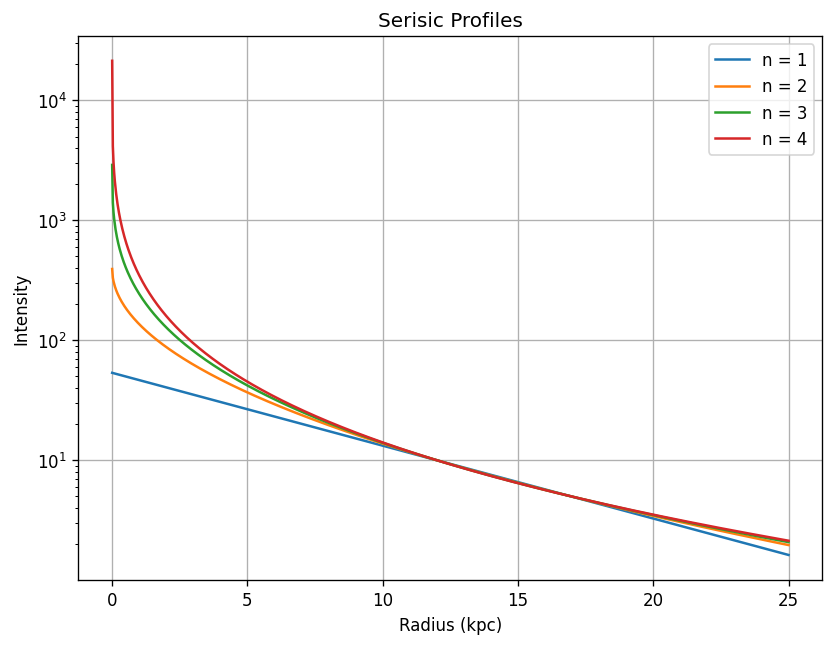

In [4]:
def sersic(R, Re, Ie, n):
    ''' Calculates the surface brightness I at the given radii R according to a
        Sérsic profile with parameters Re, Ie, and n.
    
        Input
        =====
        R : Radii at which to evaluate the function (scalar or numpy array)
        Re : Effective (half-light) radius (scalar, same units as R)
        Ie : Surface brightness at Re (scalar)
        n : Sérsic index (scalar)
            
        Output
        ======
        I : Surface brightness at each of the points in R (scalar or numpy array, same units as Ie)
    '''
        
    # Approximation for b_n
    bn = 2*n - 1./3 + (4./405)*(n**(-1)) + (46./25515)*(n**(-2)) + (131./1148175)*(n**(-3)) - (2194697./30690717750)*(n**(-4))

    # YOUR CODE HERE: Calculate and return the surface brightness at each point in R
    return np.exp(-bn*((R/Re)**(1/n)-1))*Ie

R = np.linspace(0,25,1000)
plt.figure(figsize=(8,6))
for n in range(1,5):
    plt.plot(R,sersic(R, 12, 10, n), label = "n = "+str(n))
plt.yscale("log")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Intensity")
plt.title("Serisic Profiles")
plt.grid()


## Extract the radial profile from the image data (14 points)

The code block below reads in the image data stored in the file galimg.npy, which is a two-dimensional array of surface brightness values.  The field of view is 40 kpc, and the image is 30 x 30 pixels. 

The second set of lines constructs arrays of x, y, and R at the center of each pixel, and the third set displays the image.  Read through the code below to see how the arrays are made, and execute the block to produce the image.  After executing, you will have the following arrays in memory:
- I (30x30): Surface brightness (in arbitrary units)
- x (30x30): x-location of the center of each pixel (kpc)
- y (30x30): y-location of the center of each pixel (kpc)
- R (30x30): 2D distance of each pixel from the galaxy center (kpc)

Text(0, 0.5, 'y (kpc)')

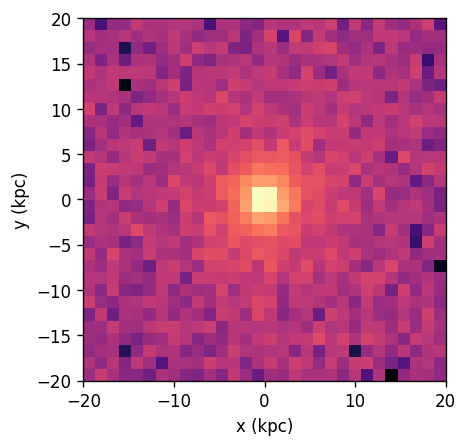

In [12]:
# Just execute this block (and read through it so you know what's going on)

# Read image into 2D numpy array
I = np.load('galimg.npy')

# Construct corresponding arrays of the x-, y-, and R-values of the center of each pixel
ncells = 30
rmax = 20
dx = rmax*2 / ncells
x1d = np.linspace(-rmax, rmax, ncells+1)[1:] - dx/2
x, y = np.meshgrid(x1d, x1d)
R = np.sqrt(x**2 + y**2)

#print(np.round(R))
# Display galaxy image
fig, ax = plt.subplots()
plt.imshow(np.log10(I).T, extent=[-20, 20, -20, 20], origin='lower', cmap='magma')
ax.set_xlabel('x (kpc)')
ax.set_ylabel('y (kpc)')


To fit a Sérsic profile, we will need to extract a one-dimensional radial profile from this two-dimensional image.  To do this, you should:
1) Define a series of circular annuli (donuts) from 0 to 20 kpc.  (I recommend about 15 donuts.)

2) Find the pixels which fall into each annulus, and

3) Calculate the average pixel value within each annulus.

Calculate and plot the radially-averaged profile pixel values below.  As before (and for every plot in this problem set), use a logarithmic y-axis.

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Image Radial Profile')

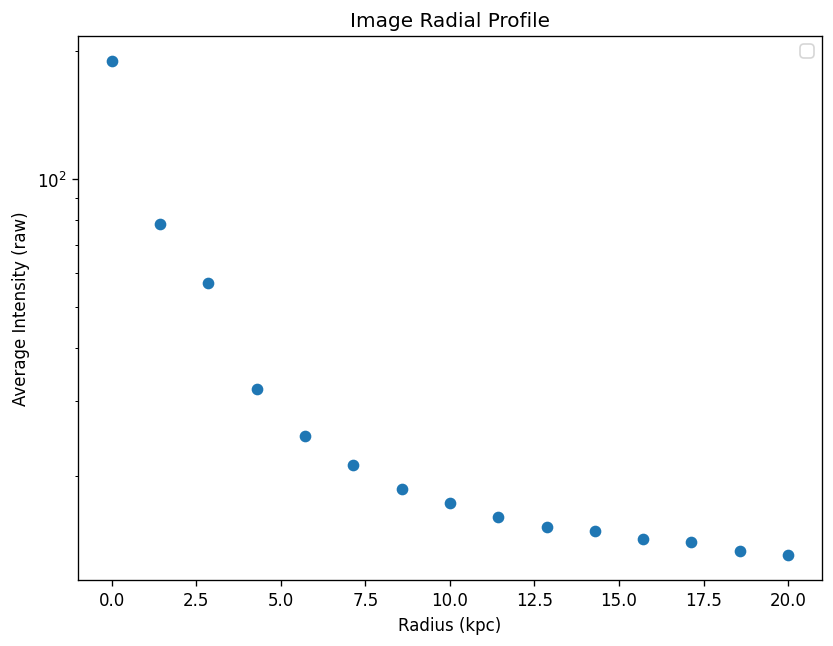

In [13]:
# define the annuli radii
rannuli = np.linspace(0,20,15)
# find the Intensity for the points in each ring 
avgIntens = [] # store the average intensity at each r in rannuli
npix=[] # store the number of data points at each annuli r in rannuli
for radius in rannuli:
     # calc the avg pixel value for each annulus 
     # b/c the R array is not integer valued we choose to group a range of radii as a single radius
     avg=np.mean(I[(R >= radius-2) & (R <= radius+2)])
     if not np.isnan(avg):
            avgIntens.append(avg)
            npix.append(len([(R >= radius-2) & (R <= radius+2)]))

plt.figure(figsize=(8,6))
plt.scatter(rannuli, avgIntens)
plt.yscale("log")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Average Intensity (raw)")
plt.title("Image Radial Profile")

This is a good start, but we are not yet ready to fit the profile!  You may have noticed from the image that there is some observational *noise*, which will give us some uncertainty on our measurements.  Let's say that we know the noise values to be normally distributed with $\mu = 12$ and $\sigma = 4$.  

Each individual *pixel* has $\sigma = 4$, but the annulus averages will each have a different $\sigma$ because they were averaged over a different number of pixels.  The annuli will have
$$\sigma_{\rm ann} = \frac{\sigma_{\rm pix}}{\sqrt{N_{\rm pix}}}$$
where $N_{\rm pix}$ is the number of pixels per annulus.  (Hopefully you already know why, because you learned error propagation in your introductory physics labs!  Ask me if you don't know where this comes from.)

Subtract the average background value $\mu$ and calculate the error $\sigma_{\rm ann}$ on each annulus, then plot the resulting profile.

Text(0.5, 1.0, 'Image Radial Profile (Noise Corrected)')

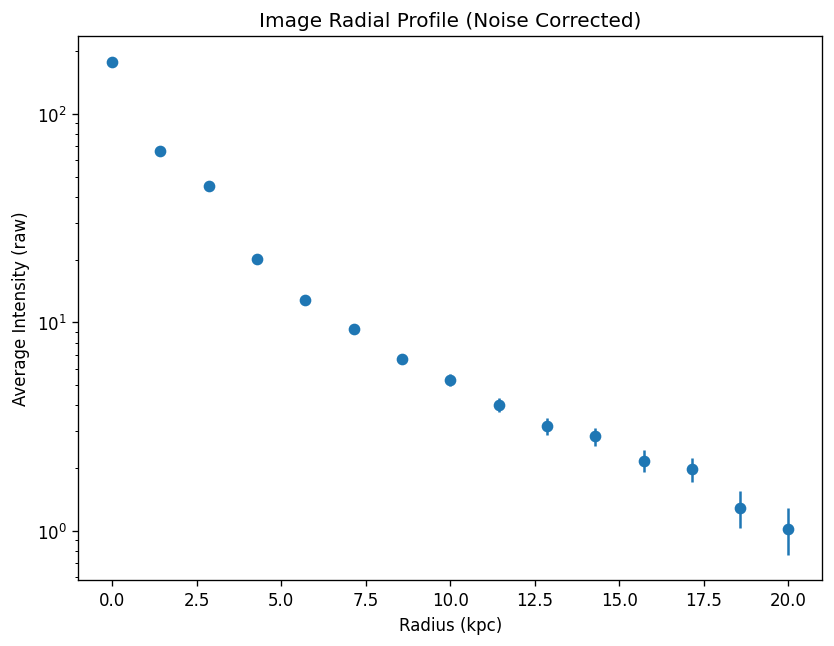

In [14]:
import math as m 
# define the annuli radii
rannuli = np.linspace(0,20,15)
# find the Intensity for the points in each ring 
I= I-12 # subtract the noise from each data point
CoravgIntens = [] # average intensity at each raddii corrected for noise
npix=[] # number of data points at each annuli 
for radius in rannuli:
     # calc the avg pixel value for each annulus 
     avg=np.mean(I[(R >= radius-2) & (R <= radius+2)])
     if not np.isnan(avg):
            CoravgIntens.append(avg)
            npix.append(len(I[(R >= radius-2) & (R <= radius+2)]))

# calc the uncertainty of each annulus 
sigAnn = np.array([4/m.sqrt(n) for n in npix])
plt.figure(figsize=(8,6))
plt.errorbar(rannuli, CoravgIntens, yerr=sigAnn, fmt='o')
plt.yscale("log")
plt.xlabel("Radius (kpc)")
plt.ylabel("Average Intensity (raw)")
plt.title("Image Radial Profile (Noise Corrected)")

## Fit a Sérsic profile (5 points)

Now we are finally ready to fit this curve!  Use ```curve_fit()``` from the scipy.optimize package to fit a Sérsic function to your extracted profile, print the resulting best-fit parameters, and plot your fit on top of the data.

Re = 6.446839358348213
Ie = 12.498223016314677
n = 1.4930839714219275


Text(0.5, 1.0, 'Image Radial Profile w/ Best Fit ')

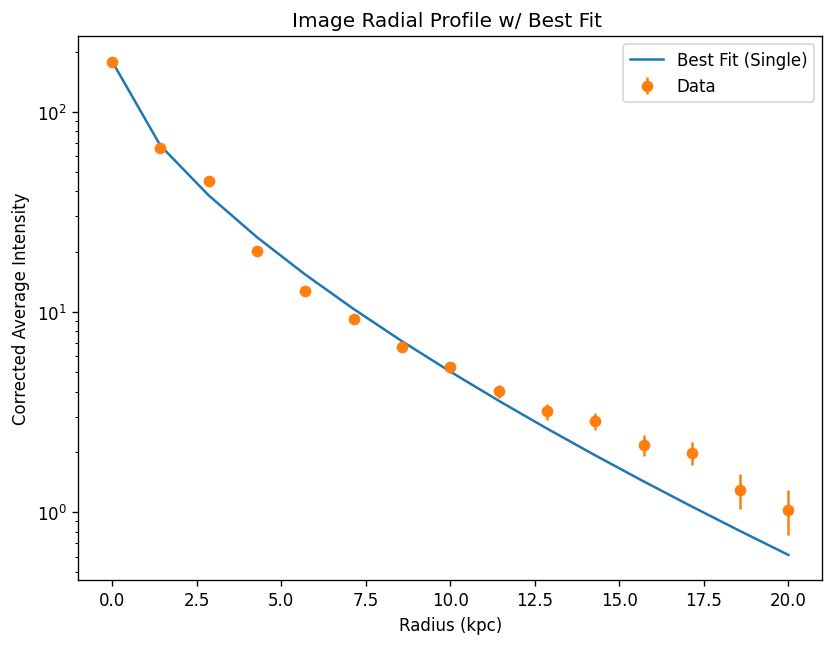

In [17]:
bestfit = curve_fit(sersic, rannuli, CoravgIntens, sigma=sigAnn)
print("Re = "+str(bestfit[0][0]))
print("Ie = "+str(bestfit[0][1]))
print("n = "+str(bestfit[0][2]))

plt.figure(figsize=(8,6))
plt.plot(rannuli, sersic(rannuli, bestfit[0][0], bestfit[0][1], bestfit[0][2]), label="Best Fit (Single)")
plt.errorbar(rannuli, CoravgIntens, yerr=sigAnn, fmt='o', label='Data')
plt.yscale("log")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Corrected Average Intensity")
plt.title("Image Radial Profile w/ Best Fit ")

## Fit a double-Sérsic profile (10 points)

It is often the case that a galaxy is not a single Sérsic component, but a composite bulge + disk system.  Write a function which returns the surface brightness of a double-Sérsic profile where one of the components (the disk) has a fixed value of $n=1$.  (Your function should take six arguments: R, $(R_e, I_e, n)$ for the bulge component, and $(R_e, I_e)$ for the disk component.)

In [18]:
# YOUR CODE HERE: Define a function for the double-Sérsic profile
def CompSer(R, Reb, Ieb , nb , Red, Ied):
    ''' Calculates the surface brightness I at the given radii R according to a
        Sérsic profile with parameters Re, Ie, and n.
    
        Input
        =====
        R : Radii at which to evaluate the function (scalar or numpy array)
        Reb : Effective (half-light) radius (scalar, same units as R) for buldge
        Ieb : Surface brightness at Re (scalar) for buldge
        nb : Sérsic index (scalar) for buldge
        Red : Effective (half-light) radius (scalar, same units as R) for disk
        Ied : Surface brightness at Re (scalar) for disk
            
        Output
        ======
        I : Surface brightness at each of the points in R (scalar or numpy array, same units as Ie)
        for galaxy characterized by a double-Serisic profile (disk + buldge) w/ a disk profile with 
        fixed n=1
    '''
    # Approximation for b_n
    bn = 2*nb - 1./3 + (4./405)*(nb**(-1)) + (46./25515)*(nb**(-2)) + (131./1148175)*(nb**(-3)) - (2194697./30690717750)*(nb**(-4))

    # YOUR CODE HERE: Calculate and return the surface brightness at each point in R
    return np.exp(-bn*((R/Reb)**(1/nb)-1))*Ieb + np.exp(-1.68*((R/Red)**(1/1)-1))*Ied

    
    

Perform another fit to the data using your double-Sérsic function, print out the best-fit parameters, and plot the fit plus each of the two components over the data.

Reb = 137.57399617515009
Ieb = 0.09256688195030618
nb = 3.5044441604899976
Red = 3.982525815916578
Ied = 19.404467738946018


Text(0, 0.5, 'Average Intensity')

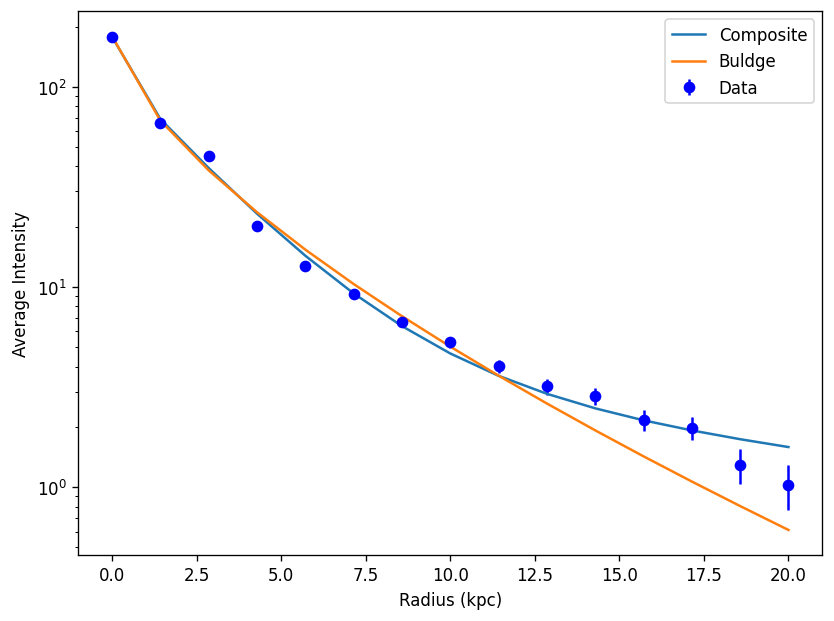

In [19]:
bestfitc = curve_fit(CompSer, rannuli, CoravgIntens, sigma=sigAnn)
print("Reb = "+str(bestfitc[0][0]))
print("Ieb = "+str(bestfitc[0][1]))
print("nb = "+str(bestfitc[0][2]))
print("Red = "+str(bestfitc[0][3]))
print("Ied = "+str(bestfitc[0][4]))

plt.figure(figsize=(8,6))
plt.plot(rannuli, CompSer(rannuli, bestfitc[0][0], bestfitc[0][1], bestfitc[0][2], bestfitc[0][3], bestfitc[0][4]), label = 'Composite')
plt.plot(rannuli, sersic(rannuli, bestfit[0][0], bestfit[0][1], bestfit[0][2]), label = 'Buldge')
plt.errorbar(rannuli, CoravgIntens, yerr=sigAnn, fmt='o', color='blue', label='Data')
plt.yscale("log")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Average Intensity")

## Calculate $\chi^2_{\rm red}$ for each fit (5 points)

The double-Sérsic profile probably reached a lower $\chi^2$ value than the single-Sérsic profile could, but because it has more parameters (and hence fewer "degrees of freedom") it may not be better in terms of "reduced $\chi^2$",
$$\chi^2_{\rm red} = \frac{\chi^2}{N_{\rm points} - N_{\rm params}}.$$

Calculate and print $\chi^2_{\rm red}$ for each fit.  Which is better?

In [22]:
# YOUR CODE HERE

# sum over i { (obsv - modeli)^2 / modeli }
avgIntens # observed
singSer = sersic(rannuli, bestfit[0][0], bestfit[0][1], bestfit[0][2]) # model 1
dubSer = CompSer(rannuli, bestfitc[0][0], bestfitc[0][1], bestfitc[0][2], bestfitc[0][3], bestfitc[0][4]) # model 2

# reduced chi single 
chiSing = np.sum( (avgIntens-singSer)**2 / singSer ) / ( len(avgIntens) - 3 )
print("Reduced Chi-square Single: " +str(chiSing))

# reduced chi double 
chidub = np.sum( ( avgIntens - dubSer)**2 / dubSer ) / ( len(dubSer) - 5)
print("Reduced Chi-square Double: " +str(chidub))
print("The Double Serisic profile is a better fit (i.e it minimizes chi-square).")

Reduced Chi-square Single: 82.22334434277343
Reduced Chi-square Double: 55.27945712389616
The Double Serisic profile is a better fit (i.e it minimizes chi-square).


**(1 point)**: How difficult was this assignment?  Did you feel prepared to take it on, or was it totally bewildering?

*Your response here*

5/10 Difficulty 
Cool to learn that you can boolean index any array object (independent of the number of dimensions) the same way. 